The [New York Social Diary](http://www.newyorksocialdiary.com) (NYSD) is a site that provides a glimpse into the social events of NYC's socialites and celebrities.
To examine the social connections between attendees at these events, I will use the captions from NYSD to build a social network/graph. For my purposes, when two individuals appear in a photo together, I interpret that as an indication of a social connection between them. This network will allow me to make statements about who is most connected, and which pairs appear together most often. To do this, I will:
1. Scrape the pages of NYSD (beautiful soup)
2. Clean and parse the captions (re)
3. Build a network of connections that describes this data (networkx)

##Scraping
I want to crawl all of the data from parties before December 1st, 2014. The [Party Pictures Archive](http://www.newyorksocialdiary.com/party-pictures) lists all the parties and dates of occurence. First, I will crawl these pages to get a list of each party page to process.

In [1]:
import urllib2
from datetime import datetime
from bs4 import BeautifulSoup
import numpy as np
import time

In [1]:
def check_party_date(pdat,datecheck):
    #Extract the span that contains the date
    party_date = pdat.find('span',attrs={'class': 'views-field views-field-created'}).text.strip()
    return datetime.strptime(party_date,'%A, %B %d, %Y') < datecheck

def parse_party_lists(urlroot,pnum):
    partylinklist = [] 
    url = urlroot+'/party-pictures?page='+str(pnum)
    print 'Parsing '+url
    #Grab the whole page
    #To handle the occasional 503 error, use a try statement and wait 5 seconds if HTTPError
    try:
        raw_page = urllib2.urlopen(url).read()
    except urllib2.HTTPError as e:
        print e.code
        time.sleep(5)
        raw_page = urllib2.urlopen(url).read()
    #Process the page w/ BeautifulSoup
    soup = BeautifulSoup(raw_page)
    partylist = soup.find('div',attrs={'class': 'view-content'})
    parties = partylist.find_all('div',attrs={'class': 'views-row'})
    for p in parties:
        # check the date to ensure it is before Dec 1, 2014
        if check_party_date(p,datetime(2014, 12, 1, 0,0)):
        # use the href link to get our link to the party
          party_link = urlroot+p.find('a').attrs['href']
        # skip the following odd link if it comes up
          if party_link != 'http://www.newyorksocialdiary.com/nysd/partypictures':
            # add to party link list
              partylinklist.append(party_link)
    return partylinklist

urlroot = "http://newyorksocialdiary.com"
for page in np.arange(1,26):
    parties = parse_party_lists(urlroot,page)
print parties[:15]

Parsing http://newyorksocialdiary.com/party-pictures?page=1
Parsing http://newyorksocialdiary.com/party-pictures?page=2
Parsing http://newyorksocialdiary.com/party-pictures?page=3
Parsing http://newyorksocialdiary.com/party-pictures?page=4
Parsing http://newyorksocialdiary.com/party-pictures?page=5
Parsing http://newyorksocialdiary.com/party-pictures?page=6
Parsing http://newyorksocialdiary.com/party-pictures?page=7
Parsing http://newyorksocialdiary.com/party-pictures?page=8
Parsing http://newyorksocialdiary.com/party-pictures?page=9
Parsing http://newyorksocialdiary.com/party-pictures?page=10
Parsing http://newyorksocialdiary.com/party-pictures?page=11
Parsing http://newyorksocialdiary.com/party-pictures?page=12
Parsing http://newyorksocialdiary.com/party-pictures?page=13
Parsing http://newyorksocialdiary.com/party-pictures?page=14
Parsing http://newyorksocialdiary.com/party-pictures?page=15
Parsing http://newyorksocialdiary.com/party-pictures?page=16
Parsing http://newyorksocialdiary

Great, that works. I have a list of pages to scrape for captions. Now I download the captions to files so I can parse them on disk. This requires finding the caption information on each party page. There are a few different formats that the website used to denote captions over the years:
* `<div class="photocaption"></div> `
* `<div id="photocaption"></div>`
* `<font size="1" face="Verdana, Arial, Helvetica, sans-serif"></font>`

I will use beautiful soup to find these elements and save their contents to a utf-8 encoded text file. 

In [2]:
import re
import codecs

In [6]:
def get_photocaptions(purl):
    caplist=[];
    # print 'Parsing '+purl
    try:
        page = urllib2.urlopen(purl).read()
    except urllib2.HTTPError as e:
        print e.code
        time.sleep(5)
        page = urllib2.urlopen(purl).read()
    psoup = BeautifulSoup(page)
    # use the photocaption class div to find captions
    pcaptionsdivclass = psoup.find_all('div', attrs={'class': 'photocaption'})
    # use the photocaption id div to find captions
    pcaptionsdivid = psoup.find_all('div', attrs={'id': 'photocaption'})
    # sometimes they hide in the td
    pcaptionstdclass = psoup.find_all('td', attrs={'class': 'photocaption'})
    # if no photocaptions found, try the old format
    pcaptionsfont = psoup.find_all('font', attrs={'face': 'Verdana, Arial, Helvetica, sans-serif','size': '1'})
    pcaptions=pcaptionsdivclass+pcaptionsdivid+pcaptionstdclass+pcaptionsfont    
    for c in pcaptions:
        # remove extraneous white space and append to caption list
        caplist.append(re.sub(r"(\s\s)+",' ',c.text).strip())
    return list(set(caplist))
        
def scrape_nysd():
    urlroot = "http://www.newyorksocialdiary.com"
    #loop through pages 1-26
    for page in np.arange(1,26):
        captions = []
        parties = parse_party_lists(urlroot,page)
        #loop through all parties and collect captions
        for p in parties:
            captions = captions+get_photocaptions(p)
            #print len(captions)
        fname = 'partypage%02i' % page
        f = codecs.open(fname,mode='wb',encoding='utf-8')
        for c in captions:
             f.write(c+'\n')
        f.close()     

scrape_nysd()      

Parsing http://www.newyorksocialdiary.com/party-pictures?page=14
Parsing http://www.newyorksocialdiary.com/party-pictures?page=15
Parsing http://www.newyorksocialdiary.com/party-pictures?page=16
Parsing http://www.newyorksocialdiary.com/party-pictures?page=17
Parsing http://www.newyorksocialdiary.com/party-pictures?page=18
Parsing http://www.newyorksocialdiary.com/party-pictures?page=19
Parsing http://www.newyorksocialdiary.com/party-pictures?page=20
Parsing http://www.newyorksocialdiary.com/party-pictures?page=21
Parsing http://www.newyorksocialdiary.com/party-pictures?page=22
Parsing http://www.newyorksocialdiary.com/party-pictures?page=23
Parsing http://www.newyorksocialdiary.com/party-pictures?page=24
Parsing http://www.newyorksocialdiary.com/party-pictures?page=25


Now I have saved all caption text to 25 files I can load from disk.

##Parsing and Cleaning captions
Some of the captions are not useful for my purposes, such as those that contain long descriptions of the event, and photo credits. First, I use process the captions through the remove_noncaptions function, which removes long captions (defined here as >250 characters), any caption that contains 'Photo', 'Click', or is blank (==''). Second, lots of regular expressions! I removed extraneous spaces, remove 'and' and 'with', remove titles, and convert a lot of 'Jill and Jack Hill' to 'Jill Hill,Jack Hill'.


In [30]:
#Load in all the captions
def load_scraped_pages():
    newcaps = []
    for page in np.arange(1,26):
        f = codecs.open('partypage%02i'%page, encoding='utf-8')
        for line in f:
            newcaps.append(re.sub(r'\n','',line))
        f.close()
    return newcaps

def remove_noncaptions(caps):
    #Remove long captions (>250 chars)
    for c in caps:
        if len(c) > 250:
            #print c
            caps.remove(c)
    #Remove photo credits
    #for c in caps:
        elif re.match('Photo',c):
            #print c
            caps.remove(c)
    #Remove Click here of NYSD Contents
    #for c in caps:
        elif re.match('Click',c):
            #print c
            caps.remove(c)
    #Remove blanks
    #for c in caps:
        elif c =='':
            #print c
            caps.remove(c)

def clean_captions(c):
    #remove space greater than 1
    c = re.sub('\s+', ' ', c)
    #remove parentheses
    c = re.sub('\(.+\)','',c)
    c = re.sub('\[.+\]','',c)
    c = re.sub('\.','',c)
    #remove titles - what a list of titles!
    c = re.sub(r"(Philanthro\w+ |Trustees |Sundance |Host |Co-Chairm[ea]n |Board |Mr |Mrs |[Ff]ounder |Smithsonian |Secretary |Chairs |Gala |Baroness |Baron |Mayor |Co-chairs |Honorable |Vice |[Dd]irector |Principal |Museum |Magician |Senior |Lady |Sir |Event |[Ee]xec |Prince* |King |Chairm[ea]n |[Hh]onoree |Governor |Commissioner |[Tt]rustee |President |Speaker |Dr |Doctor |Ambassador |Senator |Excellency |[Ee]xecutive |[Cc]ommittee |[Cc]hair |Associate |[Mm]ember[s]* |[A-H|J-Z]{2,})",'',c)    
    # with Bob and Linda Smith to Bob Smith, Linda Smith
    c = re.sub('\s+with\s+([A-Z][a-z]+)\s+and\s+([A-Z][a-z]+)\s+([A-Z][a-z]+)$',r',\1 \3,\2 \3',c)  
    # and John and Molly Garone TO ,John Garone,Molly Garone
    c = re.sub('\s+and\s+([A-Z][a-z]+)\s+and\s+([A-Z][a-z]+)\s+([A-Z][a-z]+)$',r',\1 \3,\2 \3',c)
    #Steven, Roger, Mary, and Jennifer Kumble
    c = re.sub('^([A-Z][a-z]+),\s+([A-Z][a-z]+),\s+([A-Z][a-z]+),\s+and\s+([A-Z][a-z]+)\s+([A-Z][a-z]+)',r'\1 \5,\2 \5,\3 \5,\4 \5',c)
    #Ruth, Jay, and Lucy Pack
    c = re.sub('^([A-Z][a-z]+),\s+([A-Z][a-z]+),\s+and\s+([A-Z][a-z]+)\s+([A-Z][a-z]+)',r'\1 \4,\2 \4,\3 \4',c)
    #convert Bill and Jane Smith to Bill Smith, Jane Smith
    c = re.sub('^([A-Z][a-z]+)\s+and\s+([A-Z][a-z]+)\s+([A-Z][a-z]+)',r'\1 \3,\2 \3',c)
    c = re.sub('[,:;.]\s+([A-Z][a-z]+)\s+and\s+([A-Z][a-z]+)\s+([A-Z][a-z]+)',r',\1 \3,\2 \3,',c)
    #convert Gregory  Long with Carmen and Jonathan Thain TO Gregory Long,Carmen Thain,Jonathan Thain
    c = re.sub('^([A-Z][a-z]+)\s+([A-Z][a-z]+)\s+with\s+([A-Z][a-z]+)\s+and\s+([A-Z][a-z]+)\s+([A-Z][a-z]+)',r'\1 \2,\3 \5,\4 \5',c)    
    c = re.sub('[,:;.]\s+([A-Z][a-z]+)\s+([A-Z][a-z]+)\s+with\s+([A-Z][a-z]+)\s+and\s+([A-Z][a-z]+)\s+([A-Z][a-z]+)',r'\1 \2,\3 \5,\4 \5',c)    
    #convert Bill Smith with Jane to Bill Smith, Jane Smith    
    c = re.sub('^([A-Z][a-z]+)\s+([A-Z][a-z]+)\s+with\s+([A-Z][a-z]+)',r'\1 \2,\3 \2',c)
    c = re.sub('[,:;.]\s+([A-Z][a-z]+)\s+([A-Z][a-z]+)\s+with\s+([A-Z][a-z]+)',r'\1 \2,\3 \2',c) 
    #convert and|with to ,    
    c = re.sub('\s+and\s+',',',c)
    c = re.sub('\s+with\s+',',',c)
    c = re.sub('\s*,\s+',',',c)
    c = re.sub(',,',',',c)
    c = re.sub('^[\s+|,]','',c)
    c = re.sub(',and\s+',',',c)
    c = re.sub('([\s,][Hh]is |[\s,][Hh]er |[\s,][Tt]heir |[\s,][Tt]he )',' ',c)
    return c
            
origcaps = load_scraped_pages()
remove_noncaptions(origcaps)
cleancaps = [clean_captions(x) for x in origcaps]

In [31]:
origcaps[:10]

[u'Under the tent',
 u'Iffie Okoronkwo Aitkenhead, Agenia Clark, Deborah Roberts, and Fiona Rudin',
 u'Anne Jameson and Jay Eisenhofer',
 u'Eleanor Noell',
 u'Jaime Gleicher and Jared Seligman',
 u'Dan Shedrick and Samara Heafitz',
 u'Audra Zuckerman, Michelle Smith, and Julia Harquail',
 u'Kurt Henckels and Lance Lundeberg',
 u'Caroline Dean',
 u'Judy Angelo and Doug Blonsky']

In [32]:
cleancaps[:10]

[u'Under tent',
 u'Iffie Okoronkwo Aitkenhead,Agenia Clark,Deborah Roberts,Fiona Rudin',
 u'Anne Jameson,Jay Eisenhofer',
 u'Eleanor Noell',
 u'Jaime Gleicher,Jared Seligman',
 u'Dan Shedrick,Samara Heafitz',
 u'Audra Zuckerman,Michelle Smith,Julia Harquail',
 u'Kurt Henckels,Lance Lundeberg',
 u'Caroline Dean',
 u'Judy Angelo,Doug Blonsky']

Okay, so 'Under tent' is not a person, but will be removed anyway as it has no other connections. There are several other non-person items in the list, but hopefully we can reduce their numbers in our final network with another filter. That function is remove_invalid_names. It goes through each 'name' and removes any less than 2 strings and greater than 4. There are also the reoccurring 'a friend', 'his wife', 'L. to r.', 'and friend', and the surprisingly popular 'Hospital for Special Surgery'. It winds up being a very connected node if we leave it in the network.

##Creating the network
I used the [networkx](https://networkx.github.io/) software package to create the network. After filtering, if there are at least two names in the caption, I use itertools.combinations to create every possible combination of names of size 2, then add each to the network. If the connection already exists in the network, I increase the weight by one.

In [5]:
import networkx as nx
import itertools

In [33]:
def remove_invalid_names(s):
    for n in s:
        w_cnt = len(re.split('\s+',n))
        if w_cnt<2 or w_cnt >=5:
            s.remove(n)
        if n==u'a friend':
            s.remove(n)
        if n==u'his wife':
            s.remove(n)
        if n==u'L. to r.':
            s.remove(n)
        if n==u'and friends':
            s.remove(n)
        if n==u'Hospital for Special Surgery':
            s.remove(n)
        
def add_caps_to_graph(G,caps):
    for c in caps:
        thiscap = re.split(',',c)
        remove_invalid_names(thiscap)
        if len(thiscap)>=2:
            #print thiscap
            capcombin=list(itertools.combinations(thiscap,2))
            #print capcombin
            for p in capcombin:
                if G.has_edge(p[0],p[1]):
                    G[p[0]][p[1]]['weight']+=1
                else:
                    G.add_edge(p[0],p[1],weight=1)

G=nx.Graph()
add_caps_to_graph(G,cleancaps)

In [34]:
print G.number_of_nodes()
print G.number_of_edges()

96479
181374


Whoa, this is a very large network! It doesn't make much sense trying to visualize this much data. Therefore, I keep only the nodes with a degree of 50 or greater. This means a node, or person, is photographed 50 times with other people, including repeats. Some couples make this cutoff because they are continuously photographed together and attend a lot of events. We'll see this in the visualization as a very thick line between two nodes that are very close together.

With this threshold, I reduce the network significantly (by 96,144 nodes). Then, I save the network, now containing 335 nodes to disk as a .gexf file and load it into [gephi](https://gephi.github.io/). There a are a few errors when loading into gephi, because 3 of the nodes now have no edges because we removed all the nodes they were connected to.

In [24]:
outdeg = G.degree()
to_remove = [n for n in outdeg if outdeg[n] <= 50]
print len(to_remove)

96144


In [25]:
#Remove the nodes
G.remove_nodes_from(to_remove)
#Write out .gexf file for gephi
nx.write_gexf(G, "nysd.gexf")

##Visualizing the network
In gephi, I used the HITS algorithm to compute hub scores and authority scores for each node. Nodes that have many edges to other nodes have high hub scores, while nodes that have many edges to other hubs have high authority scores.
As the name implies, the more authority a node has, the more important it is in the network. The text label of each node is scaled by its authority score. Now we can quickly observe that Jean Shafiroff and Mark Gilberson are the two greatest authorities in our network.

To get more information about the sub-networks of connections (communities) in the graph, I used the modularity measure, with edge weights on and resolution set to 1.1. This results in a modularity of 0.489, and 10 communities with sizes ranging from 7 to 51. Networks with high modularity have dense connections between the nodes within communities but sparse connections between nodes in different modules. Each community is displayed in a unique color, making it easier to see the 'Jean Shafiroff community', the 'Michael Bloomberg community', and others.

Finally, to get the layout of the network displayed nicely, I used ForceAtlas. The algorithm assigns a repulsion strength all nodes have from one another, and an attraction strength between connected nodes. Therefore, nodes that have high edge weights appear closer (couples and spouses, usually). This tends to cluster each community together. I also selected the option to distribute the attractive force so that hubs are pushed to the periphery and authorities are put more central in the display.

The communities are (listed by highest degree member):
Michael Bloomberg Network (49 members) - The former Mayor is a very philanthropic and social person. His strongest edge is to Diana Taylor, with whom he is domestic partners with.

Jean Shafiroff Network (51 members) - Before reducing the data, Jean has the most connections in this network. If you wanted to get 'in' with the NY socialite scene, Jean Shafiroff is the person to know.

Gillian Miniter Network (18 members) - also a big authority in this network is Alexadra Lebenthal

Muffie Potter Aston Network (50 members) - With a name like Muffie, you better be a socialite. Another person who is very involved in fundraising committees and getting things done.

Frederick Anderson (7 members) - Not a lot of information about Frederick Anderson. In fact, Google searches try to correct to a hockey player.

Alina Cho Network (51 members) - She is a journalist who worked for CNN until 2013. She is very fashionable and used to report on fashion. In 2011, she took the New York Times through her daily wardrobe. 

Barbara Tober Network (10 members) - A Chairman Emerita of the Museum of Arts and Design and Chairman Global Leadership Council. This network of 10 members could be entirely from one or two events she hosted.

Grace Meigher Network (11 members) - In a NYMag profile on Christopher Meigher, she is described as 'a notable beauty whom Meigher's admiring colleagues at Time Inc. dubbed Grace the Face'. Both she and her husband work in the magazine industry. 

Debbie Bancroft Network (48 members) - One of the most photographed women in New York, apparently. She's a chair or co-chair of many charity benefits.

Mark Gilbertson Network (37 members) - NYSD says he's one of the most high-profile men in the New York social scene. He started throwing cocktail parties at his Upper East Side apartment, then moved to bigger venues on Park Avenue. It seems that he is an attentive and thoughtful party host and throws several big parties every year. That probably provides lots of opportunities to get photographed with others. Who would deny the host a photograph together?



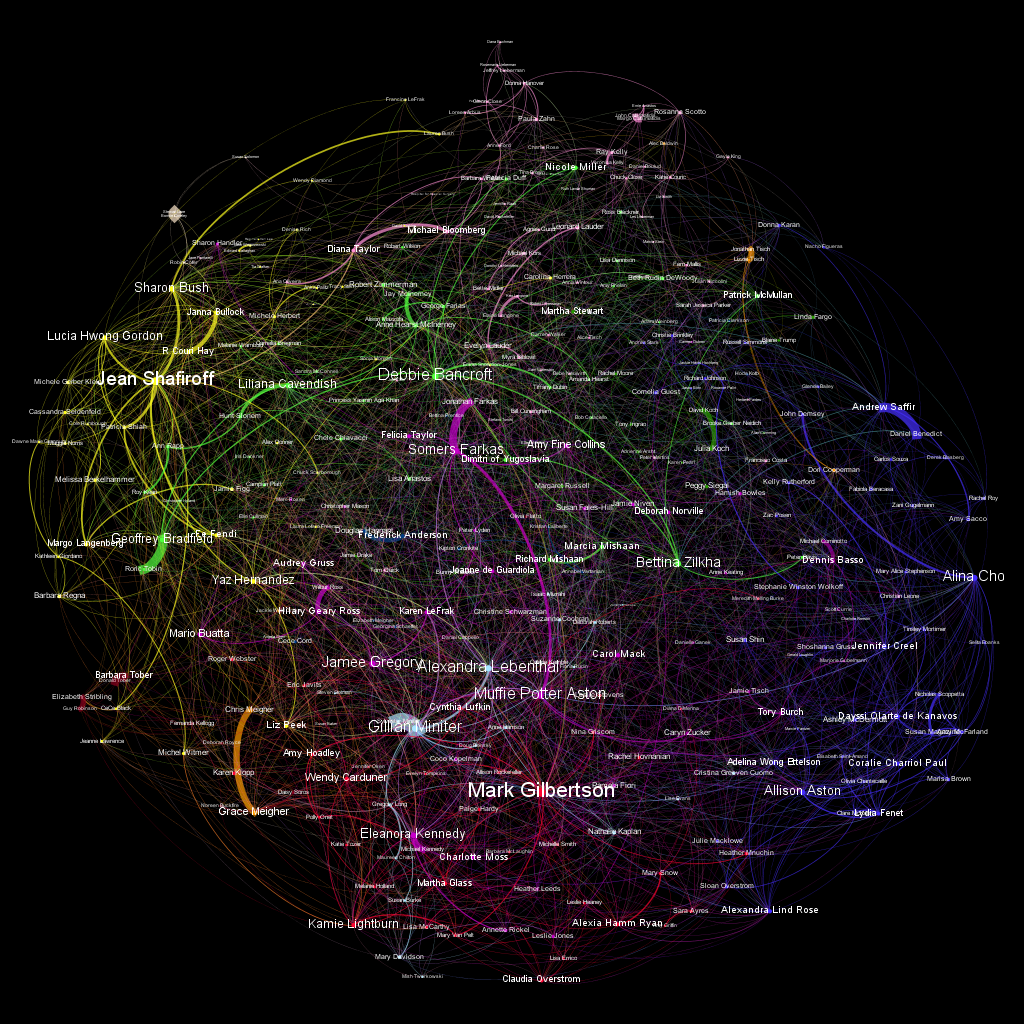

In [26]:
from IPython.display import Image
Image(filename='nysd_gephi.png') 

In [2]:
from IPython.display import HTML
HTML('<iframe src=http://briantquinn.com/sigmajs_visualization/network/index.html width=1000 height=750></iframe>')